# NNUE training

Great source on NNUE: https://official-stockfish.github.io/docs/nnue-pytorch-wiki/docs/nnue.html

## Input data

Stockfish has a lot of data available for NNUE training in the .binpack format. They have a repo for training NNUEs (nnue-pytorch) that enables efficient dataloading with this format. I don't want to use nnue-pytorch, i want to make my own NNUE training setup.

The nnue-pytorch repo also has information on training datasets for NNUEs: https://github.com/official-stockfish/nnue-pytorch/wiki/Training-datasets. They explain how to make your own dataset and link some of the datasets they generated. I will use some of this data, because generating the data myself would be too time-consuming on my hardware.

Currently using training data: test80-2024-01-jan-2tb7p.min-v2.v6.binpack.zst from https://huggingface.co/datasets/linrock/test80-2024/tree/main

This file contains billions of positions with evaluations in the .binpack format. The stockfish tools branch has a tool to covert the .binpack data into .plain data (https://github.com/official-stockfish/Stockfish/blob/tools/docs/convert.md). I used this tool and stored the first 200M evaluated positions.

### Load input data

In [1]:
import pandas as pd
import numpy as np
import torch

### Turn FEN into input layer

In [2]:
piece_dict = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5, 'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11}

def FEN_to_input(fen):
    """
    Convert a FEN string to an NNUE input vector.
    """
    # Split the FEN string into its components
    sub_FEN = fen.split(' ')
    board = sub_FEN[0]
    ranks = board.split('/')

    # Convert the board to a 1D boolean array
    # in the chess engine, position 0 corresponds to a1, so the ranks in the FEN string will need to be reversed
    input_layer = np.zeros(768, dtype = np.float32)
    position = 0
    for rank in ranks[::-1]:
        for char in rank:
            if char.isdigit():
                position += int(char)
            else:
                input_layer[position + piece_dict[char]*64] = 1

    return torch.tensor(input_layer, dtype=torch.float32)

## Model architecture

Input: a sparse, binary array of length 768. Each element of the array represents a possible combination of piece type (6), piece_color (2) and position (64) (6*2*64 = 768).

This is a very simple input feature (P feature set) set that will be improved upon later (HalfKP).

The fully connected feedfoward network has 4 hidden layers: 768 -> 1024, 1024 -> 8, 8 -> 32 and 32 -> 1.

The output is a single scalar.

In [3]:
import torch
import torch.nn as nn

class SimpleNNUE(nn.Module):
    def __init__(self):
        super(SimpleNNUE, self).__init__()
        # three fully connected layers
        self.fc1 = nn.Linear(768, 1024)
        self.fc2 = nn.Linear(1024, 8)
        self.fc3 = nn.Linear(8, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.clamp(self.fc1(x), min = 0, max = 1)
        x = torch.clamp(self.fc2(x), min = 0, max = 1)
        x = torch.clamp(self.fc3(x), min = 0, max = 1)
        x = self.fc4(x)
        return x


In [4]:
import csv
import torch
from torch.utils.data import IterableDataset, DataLoader

class CsvFenScoreDataset(IterableDataset):
    def __init__(self, csv_path, shuffle_buffer=0):
        """
        csv_path: path to CSV file with two columns: fen, score
        fen_to_tensor: function(str) -> torch.Tensor
        shuffle_buffer: size of in-memory shuffle buffer; 0 = no shuffle
        """
        super().__init__()
        self.csv_path = csv_path
        self.shuffle_buffer = shuffle_buffer

    def _row_stream(self):
        """
        Generator that yields (fen, score) tuples from the CSV file.
        """
        with open(self.csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                if not row or row[0].startswith('#'):
                    continue
                fen, score = FEN_to_input(row[0].strip()), float(row[1].strip())
                if score == 32002:
                    score = 0
                yield fen, torch.tensor(score, dtype=torch.float32)

    def __iter__(self):
        stream = self._row_stream()
        if self.shuffle_buffer > 1:

            # reservoir-style shuffle buffer
            buf = []
            for fen, score in stream:
                buf.append((fen, score))
                if len(buf) >= self.shuffle_buffer:
                    idx = torch.randint(len(buf), (1,)).item()
                    yield buf.pop(idx)
                    
            # drain remaining buffer
            while buf:
                idx = torch.randint(len(buf), (1,)).item()
                yield buf.pop(idx)
        else:
            for fen, score in stream:
                yield fen, score

In [5]:
from torch.utils.data import DataLoader

# Load the dataset
csv_path = '/home/yvlaere/projects/yvl-chess/NNUE_training/training_data/sf_training_data.csv'
dataset = CsvFenScoreDataset(csv_path, shuffle_buffer=10000)
loader = DataLoader(dataset, batch_size = 2048, num_workers = 4, pin_memory = True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nr_epochs = 500
model = SimpleNNUE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
total_size = 200000000
batch_size = 2048
steps_per_epoch = total_size // batch_size
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=steps_per_epoch, epochs=nr_epochs, pct_start=0.3, anneal_strategy='cos')
criterion = nn.MSELoss()
MAE_loss = nn.L1Loss()
lowest_MAE = 10000

# Transform the CP scores to the WDL space
scaling_factor = 400

for epoch in range(nr_epochs):
    for batch in loader:
        # get data from the dataloader
        batch_x, batch_y = batch

        # move data to GPU
        batch_x = batch_x.to(device, non_blocking = True)
        batch_y = batch_y.to(device, non_blocking = True)
        pred = model(batch_x).squeeze(1)  # remove the last dimension

        # Transform the CP scores to the WDL space
        wdl_batch_y = torch.sigmoid(batch_y / scaling_factor)
        wdl_pred = torch.sigmoid(pred / scaling_factor)

        # calculate the MSE loss
        loss = criterion(wdl_batch_y, wdl_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate MAE
        MAE = MAE_loss(wdl_batch_y, wdl_pred)
        if MAE < lowest_MAE:
            lowest_MAE = MAE
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best model saved with MAE: {lowest_MAE.item():.4f}, loss: {loss.item():.4f}")
        
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1}, MAE: {MAE.item():.4f}, lowest MAE: {lowest_MAE:.4f}")

New best model saved with MAE: 0.1143, loss: 0.0395
New best model saved with MAE: 0.1104, loss: 0.0375
New best model saved with MAE: 0.1081, loss: 0.0368
New best model saved with MAE: 0.1011, loss: 0.0330
New best model saved with MAE: 0.0961, loss: 0.0311
New best model saved with MAE: 0.0941, loss: 0.0287
New best model saved with MAE: 0.0902, loss: 0.0266
New best model saved with MAE: 0.0874, loss: 0.0258
New best model saved with MAE: 0.0846, loss: 0.0244
New best model saved with MAE: 0.0811, loss: 0.0231
New best model saved with MAE: 0.0794, loss: 0.0235
New best model saved with MAE: 0.0792, loss: 0.0231
New best model saved with MAE: 0.0781, loss: 0.0226
New best model saved with MAE: 0.0764, loss: 0.0221
New best model saved with MAE: 0.0761, loss: 0.0216


Empty bins:
Bin 0: [-32003.0, -31002.90625)
Bin 1: [-31002.90625, -30002.8125)
Bin 2: [-30002.8125, -29002.71875)
Bin 3: [-29002.71875, -28002.625)
Bin 4: [-28002.625, -27002.53125)
Bin 59: [27002.53125, 28002.625)
Bin 60: [28002.625, 29002.71875)
Bin 61: [29002.71875, 30002.8125)
Bin 62: [30002.8125, 31002.90625)


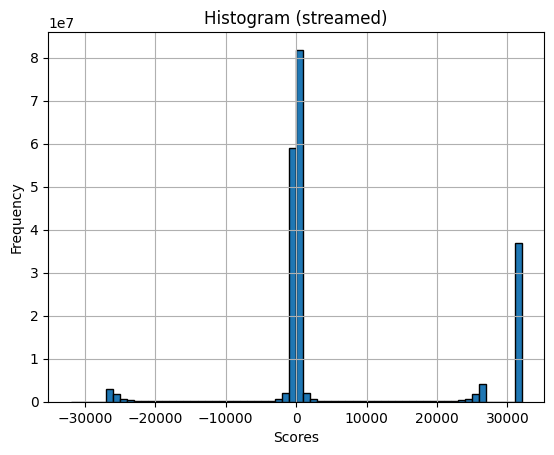

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Set number of bins
num_bins = 64
bin_edges = np.linspace(-32003, 32003, num_bins + 1)
counts = np.zeros(num_bins, dtype=int)

filename = '/home/yvlaere/projects/yvl-chess/NNUE_training/training_data/scores.txt'

# Re-read the file and bin values
with open(filename, 'r') as f:
    for line in f:
        try:
            val = float(line.strip())
            # Determine bin index
            bin_idx = np.searchsorted(bin_edges, val, side='right') - 1
            if 0 <= bin_idx < num_bins:
                counts[bin_idx] += 1
        except ValueError:
            continue

# Find empty bins
empty_bins = []
for i, count in enumerate(counts):
    if count == 0:
        left_edge = bin_edges[i]
        right_edge = bin_edges[i + 1]
        empty_bins.append((i, left_edge, right_edge))

# Print empty bin ranges
print("Empty bins:")
for i, left, right in empty_bins:
    print(f"Bin {i}: [{left}, {right})")

# Plot histogram
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge')
plt.title("Histogram (streamed)")
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [9]:
# CP to WDL conversion
scaling_factor = 400
score = torch.tensor(32000, dtype=torch.float32)
print(torch.sigmoid(score / scaling_factor))
score = torch.tensor(1000, dtype=torch.float32)
print(torch.sigmoid(score / scaling_factor))
score = torch.tensor(-1000, dtype=torch.float32)
print(torch.sigmoid(score / scaling_factor))
score = torch.tensor(0, dtype=torch.float32)
print(torch.sigmoid(score / scaling_factor))

tensor(1.)
tensor(0.9241)
tensor(0.0759)
tensor(0.5000)
